<a href="https://colab.research.google.com/github/chrisamz/142-Final-Project/blob/main/mysol_present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

We use the Metropolis Monte Carlo algorithm, which inductively constructs a sequence:

> - Take prior vector $X^{(k)} \in \mathbb R^N$, and integer $0 \le d < N$. Let $e_d$ denote the $d^{th}$ elementary basis vector
$$\begin{matrix}e_d = \left(\right. 0&\dots&0&1&0&\dots&0\left.\right)\\ &&&(d^{th}\text{ dimension})\end{matrix}$$
> - Select $r$ uniformly from
$$- \frac{\Delta}{2} < r < \frac{\Delta}{2}$$
> - Sample a random $a$ uniformly on the unit interval and set $X^{(k+1)} = X^{(k)} + re_d$ if $a < \frac{P(X^{(k)} + r_ed)}{P(X^{(k)})}$ and $X^{(k+1)} = X^{(k)}$ otherwise.
> - Set $d \leftarrow (d + 1) \mod N$ for the next step to use the next dimension.

We only need the changed point $x_k = X_{d}^{(k)}$ in order to sample from the spatial probability distribution $p(x) = |\psi(x)|^2$ given the path probability distribution $P(X) = \exp(-S/\hbar)$ for path action $S$:
- $p(x)$ can be estimated by binning the returned $x_k$.
- $\langle V \rangle$ can be estimated by taking the sample average of the $V(x_k)$.
- $\langle T \rangle$ can be estimated by the Virial Theorem from the sample average of the $\frac{1}{2}x_k V'(x_k)$.
- $\langle E \rangle$ is then $\langle V \rangle + \langle T \rangle$ by linearity of expectation.

In [ ]:
def particle_gibbs(V,N,eps,delta=1,x0=None,hbar=1,m=1):
    """ Yeilds values of a sequence generated by Gibbs sampling on the
    heat-bath quantum particle.

    V           function of potential energy
    N           number of substeps
    eps         size of substeps
    
    delta       length of interval for the monte carlo walk step (default: 1)
    x0          initial position, length N array, excluding the x_N = x_0 point
                (default: array of zeros)
    hbar        value of h-bar (default: 1)
    m           value of mass (default: 1)
    """
    if x0 is None:
        x0 = np.zeros(N)
    
    stepdim = 0 # which dimension to sample from next

    tau = N*eps
    const_ke_coeff = -m/(2*eps*hbar) #constant in front of the KE part of the sum
    const_pe_coeff = -eps/hbar       #constant in front of the PE part of the sum

    num_iters = 0
    num_accepts = 0

    while True:
        num_iters += 1
        #new point only along specific dimension
        xold = x0[stepdim]
        xnew = xold + (np.random.rand() - 0.5)*delta
        xleft = x0[(stepdim-1) % N]
        xright = x0[(stepdim+1) % N]
        #subtract old terms and add new terms inside exp
        
        action_diff = (
            const_ke_coeff*((xnew - xleft)**2 - (xold - xleft)**2
                + (xright - xnew)**2 - (xright - xold)**2 )
           +const_pe_coeff*(V(xnew) - V(xold))
        )

        # Pnew/Pold = exp(-tau Enew/hbar)/exp(-tau Eold/hbar) = ...
        if np.random.rand() < np.exp(action_diff):
            x0[stepdim] = xnew
            num_accepts += 1

        yield x0[stepdim],num_accepts/num_iters
        stepdim = (stepdim + 1) % N

Python allows for nice syntax with `yield`. A function with the `yield` keyword can be made into a generator, so we can do something like:

```
def seq():
    a = 0;
    while True:
        yield a
        a += 1

for num in seq():
    print(num)
```

Which outputs the numbers $0,1,2,\dots$ and goes on infinitely.

For our code, we collect the $x_k$ (as in above), bin them by value, and calculate Kinetic and Potential energy, as well as $x_k^2$. To properly estimate the errors, we also bin the energy values and $x_k^2$ so that correlated (sequential) values fall in the same bin. Making a guess on the correlation time, we can give an underestimate on the variance.

In [ ]:
def iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,bin_xmin,bin_xmax,bins_array,var_bin_size = 1e6, do_progress_bar = False, x_init = 0):
    KE_bin = np.zeros(round(np.ceil(collect_samples/var_bin_size)))
    PE_bin = np.zeros(round(np.ceil(collect_samples/var_bin_size)))
    x2_bin = np.zeros(round(np.ceil(collect_samples/var_bin_size)))
    cur_binsize = 0; cur_bin = 0
    
    
    bin_count = len(bins_array)
    bindx = (bin_xmax - bin_xmin)/bin_count


    #=====progress bar
    if do_progress_bar:
        progress_bar_num_parts = 100
        print("Progress\n┌" + "─"*progress_bar_num_parts + "┐\n",end="│")
        progress_bar_it = 0
    #=================

    delta = 4 * np.sqrt(eps)
    #current sample
    n = -warm_up
    for xnew,accept_rate in particle_gibbs(V,N,eps,delta=delta,x0=np.zeros(N) + x_init):
        if n < 0: #still in warm up
            n += 1
            continue
        
        if bin_xmin <= xnew and xnew <= bin_xmax:
            bins_array[int(np.floor((xnew-bin_xmin)/bindx))] += 1
        
        n += 1; cur_binsize += 1
        KE_bin[cur_bin] += xnew*dVdx(xnew) / 2
        PE_bin[cur_bin] += V(xnew)
        x2_bin[cur_bin] += xnew**2

        #bin complete?
        if cur_binsize >= var_bin_size:
            cur_bin += 1
            cur_binsize = 0


        #=====progress bar
        if do_progress_bar:
            progress_bar_next = round(progress_bar_num_parts * n/(collect_samples)) - progress_bar_it
            if progress_bar_next > 0:
                print("="*progress_bar_next,end="")
                progress_bar_it += progress_bar_next
        #=================

        if n >= collect_samples:
            break
    
    #combine

    KE_avg = np.sum(KE_bin)/n
    PE_avg = np.sum(PE_bin)/n
    x2_avg = np.sum(x2_bin)/n

    #error estimate on the bin averages
    
    KE_error = np.sum((KE_bin/var_bin_size - KE_avg)**2)/(cur_bin - 1)
    PE_error = np.sum((PE_bin/var_bin_size - PE_avg)**2)/(cur_bin - 1)
    x2_error = np.sum((x2_bin/var_bin_size - x2_avg)**2)/(cur_bin - 1)

    if do_progress_bar:
        print("│")
        print(f"Acceptance rate: {accept_rate}")

    return KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error


#potential function
V = lambda x: x**2/2
dVdx = lambda x: x

#parameters
N = 100; eps = 0.1
tau = N * eps

#suggested by paper
delta = 4 * np.sqrt(eps)

#how many samples to iterate, but throw away
warm_up = 1000 * N

#number of samples to collect
collect_samples = 1000000 * N

#collect x in bins
xmin = -4; xmax = 4; nbins = 100
bindx = (xmax - xmin)/nbins
X_binned = np.zeros(nbins,np.int64)

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5130136163836164
KE = 0.24600081429609152 ± 0.0003078848879121245
PE = 0.24600081429609152 ± 0.0003078848879121245
 E = 0.49200162859218305 ± 0.00043541498413504664
x^2 = 0.49200162859218305 ± 0.001231539551648498


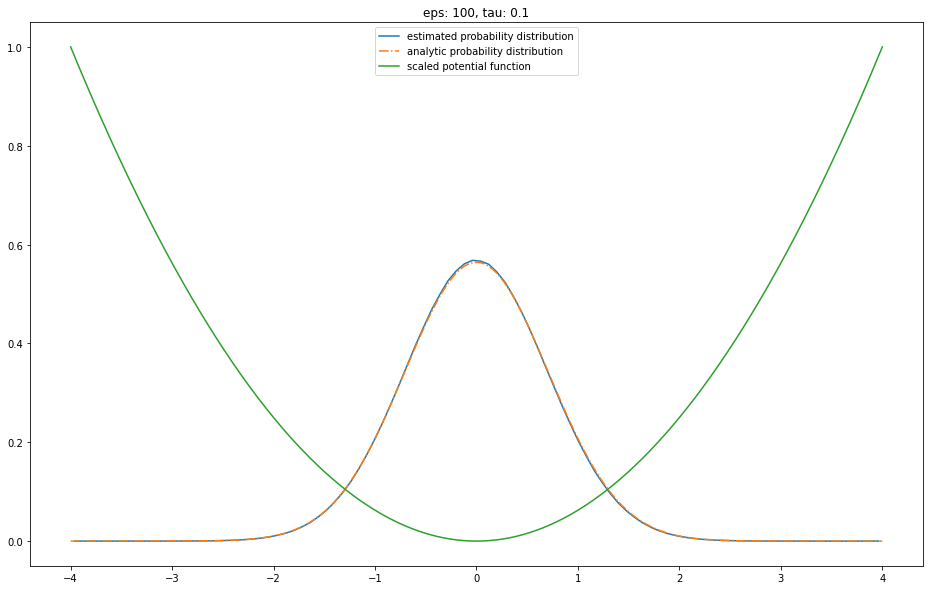

In [ ]:
KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error = iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,xmin,xmax,X_binned, do_progress_bar = True)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {100}, tau: {0.1}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
#plt.plot(np.linspace(xmin,xmax,1000), (1/np.pi)**0.5 * np.exp(-0.5*np.linspace(xmin,xmax,1000)**2)**2,"-.",label="analytic probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

In [ ]:
V = lambda x: -2*x**2 + 0.4*x**4 + 2.5
dVdx = lambda x: -4*x + 1.6*x**3

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5096163636363636
KE = 0.43219628987047193 ± 0.2987120306920762
PE = 0.7961768954711699 ± 0.030315878761380862
 E = 1.2283731853416417 ± 0.30024644841406306
x^2 = 1.9199212494640665 ± 0.13314131553578143


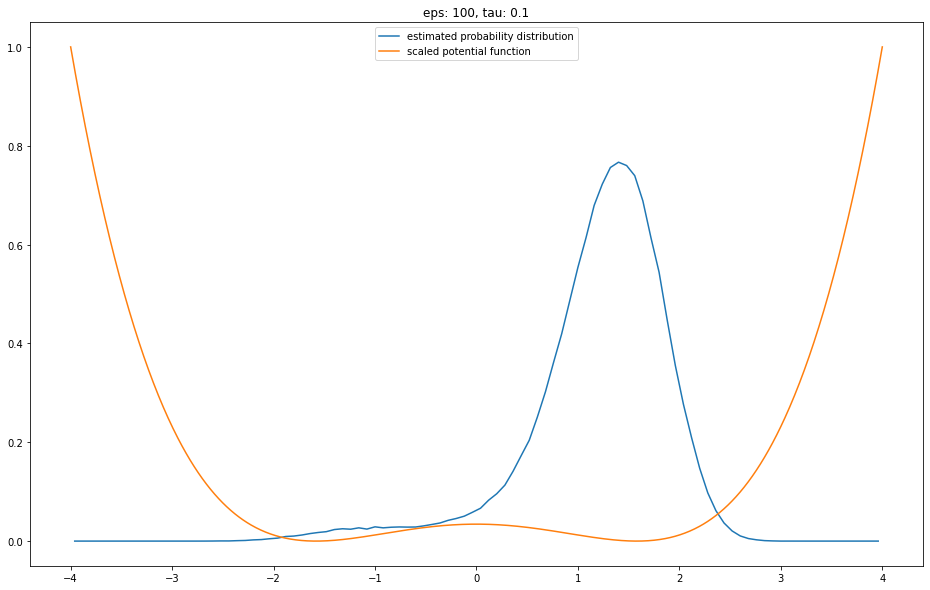

In [ ]:
X_binned = np.zeros(nbins,np.int64) #reset the bins
KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error = iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,xmin,xmax,X_binned, do_progress_bar = True)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {100}, tau: {0.1}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

Most of the time, the walker is biased towards one side since we did not run for long enough. One option to deal with it is to use multiple independent walkers and average those. Variances are additive on sums of independent random variables, so we can estimate the error on that mean.

In [ ]:
def multiple_runs(V,dVdx,N,eps,num_runs,samples_per_run,warm_up,var_bin_size = 1e6, do_progress_bar = False):

    #binning for x values
    bin_xmin = -4; bin_xmax = 4; nbins = 200; bindx = (bin_xmax - bin_xmin)/nbins
    bins_array = np.zeros(nbins,np.int64)


    KE_avg = 0; PE_avg = 0
    x2_avg = 0

    KE_errors = np.empty(num_runs)
    PE_errors = np.empty(num_runs)
    x2_errors = np.empty(num_runs)

    for current_run in range(num_runs):

        init_pos = (np.random.rand()-0.5) * 4
        KE, KE_error, PE, PE_error, x2, x2_error = iterate_walker(V,dVdx,N,eps,samples_per_run,warm_up,bin_xmin,bin_xmax,bins_array, do_progress_bar = True,x_init = init_pos)
        
        KE_errors[current_run] = KE_error
        PE_errors[current_run] = PE_error
        x2_errors[current_run] = x2_error

        KE_avg = (KE_avg * (current_run) + KE)/(current_run + 1)
        PE_avg = (PE_avg * (current_run) + PE)/(current_run + 1)
        x2_avg = (x2_avg * (current_run) + x2)/(current_run + 1)
        
    #standard deviations
    KE_sd = np.sqrt(np.sum(KE_errors))/num_runs
    PE_sd = np.sqrt(np.sum(PE_errors))/num_runs
    x2_sd = np.sqrt(np.sum(x2_errors))/num_runs

    return KE_avg, KE_sd, PE_avg, PE_sd, x2_avg, x2_sd, np.linspace(bin_xmin+bindx, bin_xmax-bindx, nbins), bins_array


In [ ]:
#number of samples to collect
samples_per_run = 10000 * N

#use multiple independent walkers
num_runs = 10

KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error, binX, bins = multiple_runs(V,dVdx,N,eps,num_runs,samples_per_run,warm_up,var_bin_size = 1e5, do_progress_bar = False)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {100}, tau: {0.1}")
plt.plot(binX,bins/sum(bins) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()